<H3>LDA model - Vaccination Tweets:</H3>  
We first start by importing all the libraries we need

In [1]:
import tqdm

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import tqdm as t

Now we define the stopwords to be removed from all the documents, for simplicity of use I extend it to consider also links -- update

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','https','co'])

importing now the data:

In [3]:
df = pd.read_csv('vaccination_tweets.csv')
s = df['text']
s_list  = s.to_list()
s_str = ' '.join(s)
print(s_list[:10])

['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF', "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm", '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P', "Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4", 'Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq', 'Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN', 'it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP', 'There have not been many bright days in 2020 but he

In [4]:
s_list2 = []
for p in tqdm.tqdm(s_list, desc = 'tqdm{} Progress Bar'):
    t =  re.sub(r"\S*https?:\S*", "", p)
    s_list2.append(t)
s_list = s_list2

#ecco l'update: regex removal dei link

tqdm{} Progress Bar: 100%|█████████████████████████████████████████████████████| 9879/9879 [00:00<00:00, 115146.35it/s]


In [5]:
print(s_list)

['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech ', "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… ", '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… ', "Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… ", 'Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… ', 'Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… ', 'it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… ', 'There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… ', 'Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna', '#Covid

define a function which, by using the gensim simple preprocess method, removes useless parts of the senteces, we then create a list in which each sentence is a list containing the words of it. Consider that all the data is the corpus, each single tweet is  the document, thus by sentence we consider the single tweet.

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(s_list))

print(data_words[:1])

[['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech']]


gensim contains the so called "phrase generators", we use them for the creation of small phrases (2 or 3 ngrams), based on the occurance of consequent word several times, defined by the mincount. the threshold does the same thing based on score attributed to each word:

In [7]:
# Build the bigram and trigram machines
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

#da manuale
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#print
print(trigram_mod[bigram_mod[data_words[0]]])

['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech']


from the generators we get the bigrams and trigrams, as well as removing the stopwords with the dictionary previously introduced and by lemmatizing them, which means to reduce to the roots a word, hence grouping different common words in a single item. We also specify which terms are accepted as reduced (lemmatized) items by using the postags avaible on the spacy <a href = https://spacy.io/api/annotation>website </a>

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] #remove the stopwords
 
def make_bigrams(texts):
    '''create bigrams for each document in corpus'''
    return [bigram_mod[doc] for doc in texts] 

def make_trigrams(texts):
    """create trigrams for each document in corpus based on the bigrams"""
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
  
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# python3 -m spacy download en_core_web_sm since en does not word anymore
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#define tags and lemmatize
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print example 
print(data_lemmatized[:1])

[['folk', 'say', 'daikon', 'paste', 'treat', 'cytokine', 'storm', 'pfizerbiontech']]


We define the data for taining and the data for the testing dividing based on 80% for training and 20% for testing.
the testing will be done by using the perplexity of the model which is:  
"A model of an unknown probability distribution p, may be proposed based on a training sample that was drawn from p. Given a proposed probability model q, one may evaluate q by asking how well it predicts a separate test sample x1, x2, ..., xN also drawn from p. 
The perplexity of the model q is defined as "

In [10]:
#separation of data in train and test:
from sklearn.model_selection import train_test_split
data_lemm_train, data_lemm_test  = train_test_split(data_lemmatized, test_size = 0.2)

In [11]:
np.shape(data_lemm_train)

W:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(7903,)

In [12]:
id2w = corpora.Dictionary(data_lemmatized)

In [13]:
# Create Dictionary with the training data
i2w_test = corpora.Dictionary(data_lemm_test)

# Create Corpus with the training data
texts_for_test = data_lemm_test

# TDF of the train data
corpus_of_test = [i2w_test.doc2bow(text) for text in texts_for_test]


In [14]:
# Create Dictionary with the training data
i2w_train = corpora.Dictionary(data_lemm_train)

# Create Corpus with the training data
texts_for_train = data_lemm_train

# TDF of the train data
corpus_of_train = [i2w_train.doc2bow(text) for text in texts_for_train]


In [15]:
#total
i2w = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [i2w_test.doc2bow(text) for text in texts_for_test]

In [16]:
print(len(i2w_test),len(texts_for_test),len(corpus_of_test),len(i2w_train),len(texts_for_train),len(corpus_of_train))

4377 1976 1976 10234 7903 7903


examples for perplexity and coherences:

I now had the choice to either estimate the best topic number with the mallet library or by doing it manually in within python using the coherence and perplexity already provided with the Gensim.models module. Since I had to change PCs, i decided to use something which did not required the creation of other environments:

In [17]:
print(len(corpus_of_train),len(i2w_train),)

7903 10234


In [18]:
#mallet_path = "C:\mallet\bin\mallet.bat" # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
#id2word.filter_extremes(no_below=167, keep_tokens=None)
#mm=[id2word.doc2bow(words) for words in data_words]
#for m in ldamallet[mm]:
#    topics_docs.append(m)

#Considering 1-15 topics, as the last is cut off
import tqdm
from gensim.models import ldamulticore
num_topics = list(range(1,15 )) #for test reasons we will have it up to 3 topiucs --> originally it is up to 16
num_keywords = 14 #change back to 15
i = 1
LDA_models = {}
LDA_topics = {}
perplexity_tot_test = {}
for i in tqdm.tqdm(num_topics):
    LDA_models[i] = ldamulticore.LdaMulticore(workers=3,corpus=corpus_of_train,
                             id2word=i2w_train,
                             num_topics=i,
                             chunksize=100,
                             passes=20,
                             random_state=42)
    perplexity_tot_test[i] = LDA_models[i].log_perplexity(corpus_of_test) #seeing the best model based on a

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [03:15<00:00, 13.98s/it]


In [19]:
from gensim.matutils import jaccard
#jaccard(bow_water, bow_bank)
LDA_stability = {}
for i in tqdm.tqdm(range(0, len(num_topics)-1)):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2606.65it/s]


we can use either the jaccard similarity or perplexity to compare the models:

In [20]:
print(mean_stabilities)

[0.4579710144927536, 0.5594246815985947, 0.6496305868044999, 0.7302361913448869, 0.8008594912729161, 0.8169223976095695, 0.8490050629724543, 0.8683508175794599, 0.9098399916419241, 0.9261750053489184, 0.9254504344301291, 0.9365111647302283, 0.9395307854753169]


In [21]:
print(LDA_topics)

{1: [['pfizerbiontech', 'vaccine', 'covid', 'pfizer', 'dose', 'get', 'first', 'covidvaccine', 'today', 'receive', 'vaccination', 'thank', 'second', 'biontech']], 2: [['pfizerbiontech', 'vaccine', 'dose', 'get', 'covid', 'first', 'today', 'receive', 'covidvaccine', 'pfizer', 'thank', 'second', 'vaccination', 'day'], ['vaccine', 'pfizerbiontech', 'covid', 'pfizer', 'biontech', 'moderna', 'people', 'coronavirus', 'say', 'astrazeneca', 'amp', 'new', 'pfizervaccine', 'effective']], 3: [['vaccine', 'pfizerbiontech', 'pfizer', 'approve', 'health', 'biontech', 'amp', 'coronavirus', 'india', 'country', 'early', 'know', 'emergency', 'follow'], ['vaccine', 'pfizerbiontech', 'covid', 'pfizer', 'moderna', 'biontech', 'astrazeneca', 'say', 'coronavirus', 'people', 'pfizervaccine', 'new', 'amp', 'covidvaccine'], ['pfizerbiontech', 'vaccine', 'dose', 'get', 'covid', 'first', 'today', 'receive', 'thank', 'second', 'covidvaccine', 'pfizer', 'vaccination', 'day']], 4: [['pfizerbiontech', 'fully_vaccinate

to estimate stability you can either use the above method or the below one

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))


In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [22]:
print(mean_stabilities)

[0.4579710144927536, 0.5594246815985947, 0.6496305868044999, 0.7302361913448869, 0.8008594912729161, 0.8169223976095695, 0.8490050629724543, 0.8683508175794599, 0.9098399916419241, 0.9261750053489184, 0.9254504344301291, 0.9365111647302283, 0.9395307854753169]


In [23]:
coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized, dictionary=i2w_train, coherence='c_v').get_coherence()\
              for i in tqdm.tqdm(num_topics[:-1])]

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:05<00:00,  5.06s/it]


In [54]:
#checking all weights attributed to the jaccard_similarity for the decision making 
ntop = []
for weight in range(1,200,1):
    coh_sta_diffs = [coherences[i] - (weight/100)*mean_stabilities[i] for i in range(num_keywords)[:-1]]
    coh_sta_max = max(coh_sta_diffs)
    coh_sta_max_idxs = [i for i, j in tqdm.tqdm(enumerate(coh_sta_diffs)) if j == coh_sta_max]
    ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
    ideal_topic_num = num_topics[ideal_topic_num_index]
    ntop.append(ideal_topic_num)
print(ntop)

13it [00:00, 13063.24it/s]
13it [00:00, ?it/s]
13it [00:00, 13007.15it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, 13044.49it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, 106.85it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, 13019.57it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [00:00, ?it/s]
13it [0

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [55]:
weight = 0.5 #weight in the decision making of the stability
coh_sta_diffs = [coherences[i] - weight*mean_stabilities[i] for i in tqdm.tqdm(range(num_keywords)[:-1])] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in tqdm.tqdm(enumerate(coh_sta_diffs)) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]
best_perp_in_test = max(x for x in perplexity_tot_test.values())

100%|██████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]
13it [00:00, ?it/s]


In [56]:
for i, v in perplexity_tot_test.items(): 
    if best_perp_in_test == v:
        best_perp_topic = i
        
print(best_perp_topic) #

1


In [57]:
print(ideal_topic_num)

2


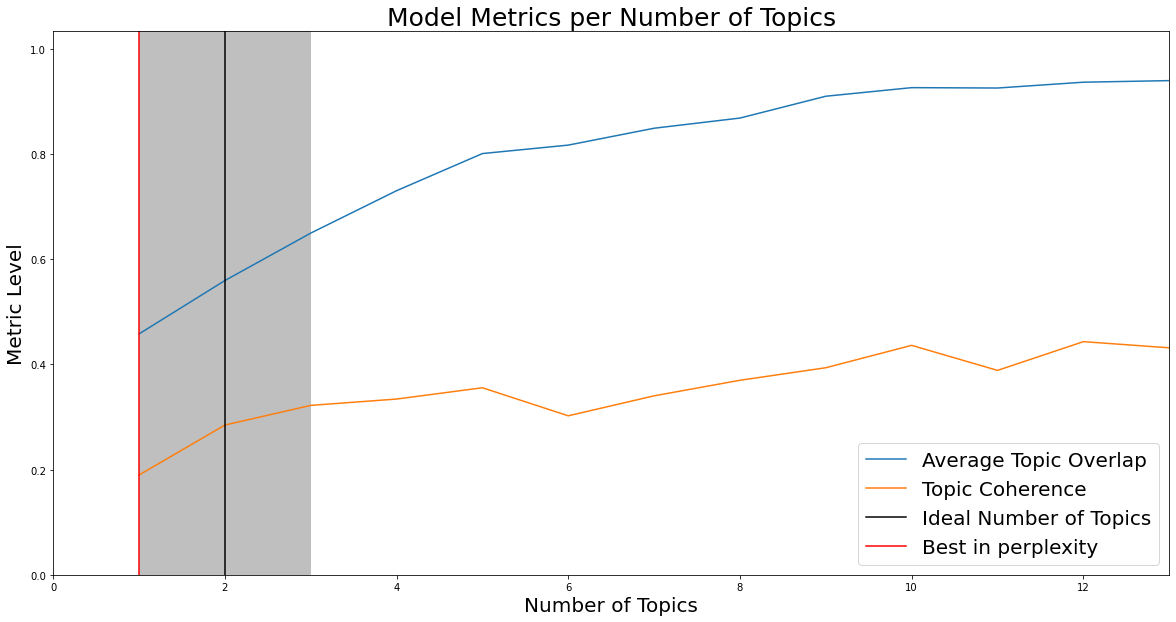

In [58]:
import seaborn as sns
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')


ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

ax.axvline(x=best_perp_topic, label='Best in perplexity', color='red')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([0, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   



In [59]:
lt_of_perp_pertop = []
for i in perplexity_tot_test.values():
    lt_of_perp_pertop.append(i)

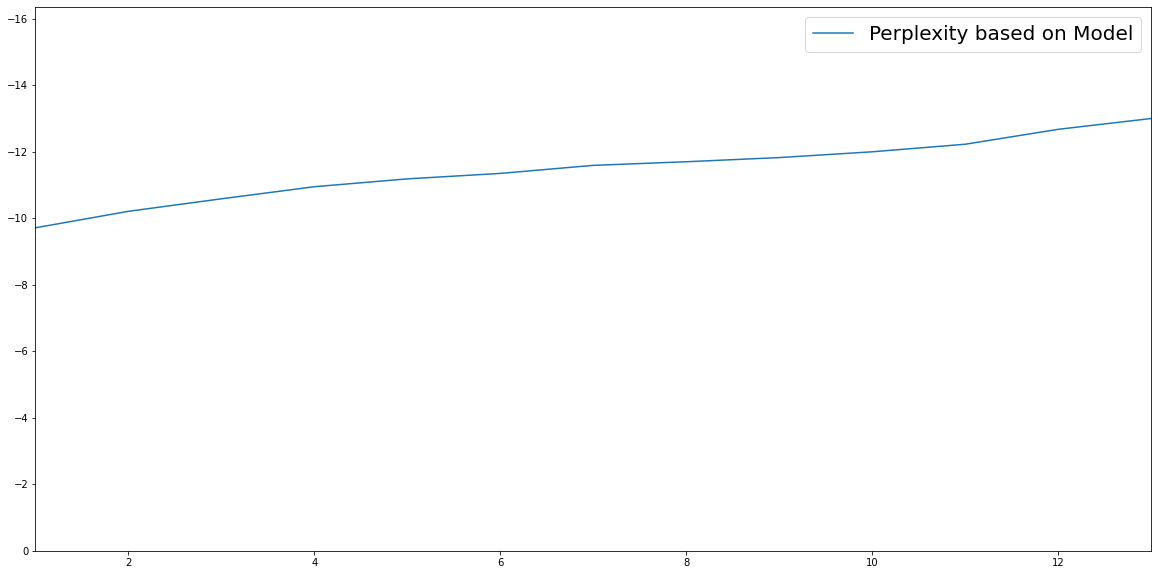

In [60]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics, y=lt_of_perp_pertop, label = "Perplexity based on Model")
y_max = min(lt_of_perp_pertop[:len(lt_of_perp_pertop)]) - 3
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
plt.legend(fontsize=20)
plt.show()  

#the lower the perplexity the better the prediction of the following word and the generalization, this suggest that i should keep the model with less topics

In [34]:
lda_modelfinal = gensim.models.ldamodel.LdaModel(corpus=corpus_of_train,
                                           id2word=i2w_train,
                                           num_topics=ideal_topic_num, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
lda_modelfinal.print_topics()
# Compute Perplexity
print('\nPerplexity: ', lda_modelfinal.log_perplexity(corpus_of_train))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_modelfinal, texts=data_lemmatized, dictionary=i2w_train, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.453590041798933

Coherence Score:  0.2484376989262025


In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_modelfinal, corpus_of_train, i2w_train)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.114662  0.0       1        1  56.113654
1     -0.114662  0.0       2        1  43.886346, topic_info=               Term         Freq        Total Category  logprob  loglift
8           vaccine  3865.000000  3865.000000  Default  30.0000  30.0000
64            covid  2162.000000  2162.000000  Default  29.0000  29.0000
2               get  1013.000000  1013.000000  Default  28.0000  28.0000
54          moderna   522.000000   522.000000  Default  27.0000  27.0000
15             dose  1169.000000  1169.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3695            sym   120.034112   243.941921   Topic2  -5.5175   0.1144
10232         fibro   119.995765   243.819803   Topic2  -5.5179   0.1146
10233  fibromyalgia   119.995765   243.819803   Topic2  -5.5179   0.1146
1771        trigger   120.068756   252.788415   Topic2  -5.5172   0.0791
405             try   120.072027   268.819944   Topic2  -5.5172   0.0176

[128 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
66        1  0.049264          amp
66        2  0.950100          amp
208       1  0.016580      approve
208       2  0.986538      approve
135       1  0.035369  astrazeneca
...     ...       ...          ...
451       2  0.019320         well
42        1  0.987354         work
42        2  0.013415         work
101       1  0.029250         year
101       2  0.965256         year

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [37]:
lda_modelfinal.update(corpus_of_test)

In [38]:
lda_modelfinal.print_topics()

[(0,
  '0.098*"vaccine" + 0.092*"also" + 0.033*"bri" + 0.027*"death" + 0.018*"eff" + 0.013*"update" + 0.010*"sport" + 0.010*"care" + 0.009*"volunteer" + 0.008*"novel"'),
 (1,
  '0.041*"pfizervaccine" + 0.037*"bri" + 0.020*"eff" + 0.013*"sport" + 0.011*"house" + 0.010*"wait" + 0.009*"novel" + 0.009*"vaccine" + 0.008*"life" + 0.008*"tralee"')]

In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_modelfinal.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_modelfinal, texts=data_lemmatized, dictionary=i2w, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.001654686624885

Coherence Score:  0.7015486350818225


After all the training, and by updating with the testing (we can call it validation data) we obtain an even better version of the machine, with lower perplexity and higher coherence.

In [ ]:
from gensim.test.utils import datapath
for  i in LDA_models:
    temp_file = datapath(f"D:/utente/Desktop/B/UPDATE/last proj/vaccination tweets/backupmodell/model_{i}")
    LDA_models[i].save(temp_file)

In [ ]:
print(np.shape( corpus),np.shape(i2w),np.shape(lda_modelfinal))